In [5]:
import pandas as pd
import os
import re
from sklearn.model_selection import train_test_split
import csv
import asyncio
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from dotenv import load_dotenv
from sklearn.metrics import normalized_mutual_info_score
from sklearn.datasets import fetch_20newsgroups

# Load environment variables
load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

# Fetch 20 newsgroups dataset
newsgroups_data = fetch_20newsgroups(subset='all')

# Define label groups for mapping
label_groups = {
    'comp.graphics': 'Technology',
    'comp.os.ms-windows.misc': 'Technology',
    'comp.sys.ibm.pc.hardware': 'Technology',
    'comp.sys.mac.hardware': 'Technology',
    'comp.windows.x': 'Technology',

    'rec.autos': 'Vehicles',
    'rec.motorcycles': 'Vehicles',

    'rec.sport.baseball': 'Sport',
    'rec.sport.hockey': 'Sport',

    'sci.crypt': 'Cryptographics',
    'sci.electronics': 'Electronics',
    'sci.med': 'Medical',
    'sci.space': 'Space',

    'talk.politics.guns': 'Politics',
    'talk.politics.mideast': 'Politics',
    'talk.politics.misc': 'Politics',
    'talk.religion.misc': 'Religion',

    'alt.atheism': 'Religion',
    'misc.forsale': 'Miscellaneous',
}

# Convert to a DataFrame
data = pd.DataFrame({
    'text': newsgroups_data.data,
    'label_original': newsgroups_data.target
})

# Map the original numeric labels to the corresponding category names
data['label_original'] = data['label_original'].map(lambda x: newsgroups_data.target_names[x])

# Map the original category names to the custom label groups
data['label'] = data['label_original'].map(label_groups)
print(data[["label", "label_original"]])

def split_train_test(data):
    # Remove NaN
    data = data.dropna(how="any")
    train, test = train_test_split(data, test_size=0.05, random_state=42)

    train = train.sort_values(by='label')
    train_first_doc = train.groupby('label').first().reset_index()

    train_first_doc['div'] = 'train'
    test['div'] = 'test'

    return test, train_first_doc

# Split the data
test_df, instruction_df = split_train_test(data)
test_df["name"] = range(1, len(test_df) + 1)

# Print some details
print(test_df.iloc[5])
print("Test Length: ", len(test_df))
print("Instruction Length: ", len(instruction_df))
print("Original Length: ", len(data))
print(test_df.columns)




             label            label_original
0            Sport          rec.sport.hockey
1       Technology  comp.sys.ibm.pc.hardware
2         Politics     talk.politics.mideast
3       Technology  comp.sys.ibm.pc.hardware
4       Technology     comp.sys.mac.hardware
...            ...                       ...
18841      Medical                   sci.med
18842  Electronics           sci.electronics
18843   Technology  comp.sys.ibm.pc.hardware
18844   Technology             comp.graphics
18845     Vehicles                 rec.autos

[18846 rows x 2 columns]
text              From: sp1henhj@edit (Henrik Balthazar Hjort)\n...
label_original                                       comp.windows.x
label                                                    Technology
div                                                            test
name                                                              6
Name: 5545, dtype: object
Test Length:  893
Instruction Length:  10
Original Length:  18846
In

In [6]:
def make_prompts(bbc_instructions, bbc_data):
    

    prompts = []
    
    # General instructions and fixed texts
    general_instruction = (
        "You are a perfect topic modeling machine. Given a text and the different topics, "
        "you will classify the following text to the correct topic. First you will receive the topics, "
        "afterwards an example and finally the text you have to assign one of the before mentioned topics to."
    )
    topics = "The topics are sport, technology, politics, vehicles, religion, miscellaneous, cryptographics, electronics, medical and space. Please make sure, you know the topics and their meaning."
    transition_to_examples = "Now an example for each of the categories will follow."
    transition_to_text_to_classify = (
        "Now the text, you have to classify will follow. Please assess its topic and answer only the topic of it."
    )

    # Iterate through the test DataFrame rows
    for _, test_row in bbc_data.iterrows():
        prompt = general_instruction + "\n" + topics + "\n" + transition_to_examples + "\n"

        # Iterate through instruction DataFrame to add examples
        for _, instruction_row in bbc_instructions.iterrows():
            category = instruction_row['label']
            example_text = instruction_row['text']
            prompt += f"For the following text : \n{example_text}\nThe correct answer would be: {category}\n"

        # Add the actual text to classify from the test set
        text_to_classify = test_row['text']
        prompt += transition_to_text_to_classify + "\n" + text_to_classify + "\n"
        name = f"{test_row['name']}"
        
        #print(name)
        prompt_dict = {}
        prompt_dict[name] = prompt
        prompts.append(prompt_dict)
    return prompts            

prompts = make_prompts(instruction_df, test_df)

print(prompts[0])
print(len(prompts))


{'1': 'You are a perfect topic modeling machine. Given a text and the different topics, you will classify the following text to the correct topic. First you will receive the topics, afterwards an example and finally the text you have to assign one of the before mentioned topics to.\nThe topics are sport, technology, politics, vehicles, religion, miscellaneous, cryptographics, electronics, medical and space. Please make sure, you know the topics and their meaning.\nNow an example for each of the categories will follow.\nFor the following text : \nFrom: karn@servo.qualcomm.com (Phil Karn)\nSubject: Re: Keeping Your Mouth Shut (was: Hard drive security)\nNntp-Posting-Host: servo.qualcomm.com\nReply-To: karn@chicago.qualcomm.com\nOrganization: Qualcomm, Inc\nLines: 37\n\nIn article <C5K1CE.51A@sunfish.usd.edu>, vkub@charlie.usd.edu (Vince Kub) writes:\n|> Now,\n|> the original scheme as suggested here would be to have the key disappear if\n|> certain threatening conditions are met. Once th

In [7]:


async def prompt_llm(prompt):
    semaphore = asyncio.Semaphore(5)
    async with semaphore:
        name = list(prompt.keys())[0]
        promptAI = prompt[name]   

        generation_config = {
        "temperature": 1,
        "top_p": 0.95,
        "top_k": 40,
        "max_output_tokens": 8192,
        "response_mime_type": "text/plain",
        }
        model = genai.GenerativeModel(
        model_name="gemini-1.5-pro",
        generation_config=generation_config,
        safety_settings = {HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
                    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
                    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE},
        )
        
        chat_session = model.start_chat(
        history=[])
        answer = chat_session.send_message(promptAI)
        text_response = answer._result.candidates[0].content.parts[0].text
        
        return {name : text_response}

In [8]:
genai.configure(api_key=GEMINI_API_KEY)
async def prompt_orchestrator():
      batch_size = 5
      avatiables = []
      batches = [prompts[i:i + batch_size] for i in range(0, len(prompts), batch_size)]

      # Ensure the last batch is smaller if it's less than batch_size
      if len(batches[-1]) < batch_size:
            remaining = len(batches[-1])
            batches[-1] = prompts[-remaining:]

      # If the last batch is part of the earlier slices and it's less than batch_size
      if len(prompts) % batch_size != 0:
            remaining = len(prompts) % batch_size
            batches[-1] = prompts[-remaining:]

      try:
            for batch in batches:
                  avatiables_batch = await asyncio.gather(*(prompt_llm(prompt) for prompt in batch))
                  avatiables.extend(avatiables_batch)
                  print("sleeping")
                  await asyncio.sleep(1)

      except Exception as e:
            print(f"An error occurred: {e}. Returning the accumulated results.")
            return avatiables
      
      return avatiables

results = await prompt_orchestrator()


print(results)


sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
s

In [9]:
def add_correct_anser(results, test_df):
    result_with_correct_answer = []
    for result in results:
        for key, value in result.items():
            value = value.replace("\n", "")
            value = value.replace(" \n", "")
            value = value.replace(" ","")
            value = value.replace("*","")
            value = value.lower()
            matching_rows = test_df.loc[test_df['name'] == int(key), 'label']
            if not matching_rows.empty:
                if type(matching_rows.values[0]) == float: 
                    print(f"Nan value", matching_rows.values[0])
                else:
                    category_value = matching_rows.values[0]
                    category_value = category_value.lower()
                    result_with_correct_answer.append({key: (value, category_value)})
            else:
                print(f"No matching category found for key: {key}")
                result_with_correct_answer.append({key: (value, None)})
    return result_with_correct_answer
results_with_correct_answer = add_correct_anser(results, test_df)
print(len(results_with_correct_answer))
print(results_with_correct_answer)

893
[{'1': ('electronics', 'electronics')}, {'2': ('technology', 'technology')}, {'3': ('politics', 'politics')}, {'4': ('vehicles', 'vehicles')}, {'5': ('technology', 'technology')}, {'6': ('technology', 'technology')}, {'7': ('politics', 'vehicles')}, {'8': ('technology', 'technology')}, {'9': ('miscellaneous', 'miscellaneous')}, {'10': ('cryptographics', 'cryptographics')}, {'11': ('vehicles', 'vehicles')}, {'12': ('vehicles', 'vehicles')}, {'13': ('vehicles', 'vehicles')}, {'14': ('vehicles', 'vehicles')}, {'15': ('electronics', 'technology')}, {'16': ('technology', 'technology')}, {'17': ('politics', 'politics')}, {'18': ('technology', 'technology')}, {'19': ('technology', 'technology')}, {'20': ('vehicles', 'vehicles')}, {'21': ('vehicles', 'vehicles')}, {'22': ('sport', 'sport')}, {'23': ('technology', 'technology')}, {'24': ('sport', 'sport')}, {'25': ('sport', 'sport')}, {'26': ('space', 'space')}, {'27': ('technology', 'technology')}, {'28': ('space', 'space')}, {'29': ('misc

In [10]:
import difflib
from thefuzz import fuzz
def post_process(results):
    test_df_copy = test_df.copy()  
    test_df_copy.loc['result'] = None
    string_list = ["religion", "politics","sport","technology", "vehicles", "cryptographics","electronics","medical","space","miscellaneous"]
    science_list = ["cryptographics","electronics","medical","space","Cryptographics","Electronics","Medical","Space"]
    test_df_copy["name"] = test_df_copy["name"].astype(str)
    final_results = []
    print(test_df_copy.columns)
    for result_loop in results:
            similarity = []
            for string in string_list:
                  similarity.append([fuzz.partial_ratio(list(result_loop.values())[0][0], string), string])
            max_similarity = max(similarity)

            # Check if the maximum similarity exceeds the threshold
            if max_similarity[0] > 60:
                  final_results.append({list(result_loop.keys())[0]: (max_similarity[1], list(result_loop.values())[0][1])})
                  test_df_copy.loc[test_df_copy['name'] == list(result_loop.keys())[0]+".0", 'result'] = max_similarity[1]

            else:
                  final_results.append({list(result_loop.keys())[0]: ("", list(result_loop.values())[0][1])})
                  test_df_copy.loc[test_df_copy['name'] == list(result_loop.keys())[0], 'result'] = ""
    print(final_results)
    for item in final_results:
        for key, (string1, string2) in item.items():
            # Replace string1 if it's in science_list
            if string1 in science_list:
                string1 = "science"
            # Replace string2 if it's in science_list
            if string2 in science_list:
                string2 = "science"
            # Update the dictionary with the modified values
            item[key] = (string1, string2)
    print(final_results)
    
    for index, row in test_df_copy.iterrows():
        # Check if the value in the 'result' column is in science_list
        if row['result'] in science_list:
            test_df_copy.at[index, 'result'] = "science"
        
        # Check if the value in the 'label' column is in science_list
        if row['label'] in science_list:
            test_df_copy.at[index, 'label'] = "science"
    

    test_df_copy.to_csv(r"E:\uni\NLP group project\gemini_20newsgroups.csv", index=False)
    return final_results


result_with_correct_answer_pre_post_process = results_with_correct_answer
print(result_with_correct_answer_pre_post_process)
results_with_correct_answer = post_process(result_with_correct_answer_pre_post_process)
print(results_with_correct_answer)
#print(test_df[["name", "result"]])  
#print("result:")
#print(test_df[["result"]])

[{'1': ('electronics', 'electronics')}, {'2': ('technology', 'technology')}, {'3': ('politics', 'politics')}, {'4': ('vehicles', 'vehicles')}, {'5': ('technology', 'technology')}, {'6': ('technology', 'technology')}, {'7': ('politics', 'vehicles')}, {'8': ('technology', 'technology')}, {'9': ('miscellaneous', 'miscellaneous')}, {'10': ('cryptographics', 'cryptographics')}, {'11': ('vehicles', 'vehicles')}, {'12': ('vehicles', 'vehicles')}, {'13': ('vehicles', 'vehicles')}, {'14': ('vehicles', 'vehicles')}, {'15': ('electronics', 'technology')}, {'16': ('technology', 'technology')}, {'17': ('politics', 'politics')}, {'18': ('technology', 'technology')}, {'19': ('technology', 'technology')}, {'20': ('vehicles', 'vehicles')}, {'21': ('vehicles', 'vehicles')}, {'22': ('sport', 'sport')}, {'23': ('technology', 'technology')}, {'24': ('sport', 'sport')}, {'25': ('sport', 'sport')}, {'26': ('space', 'space')}, {'27': ('technology', 'technology')}, {'28': ('space', 'space')}, {'29': ('miscella

KeyError: "['result'] not in index"

In [11]:
for item in results_with_correct_answer:
    if isinstance(item, dict):  # Ensure item is a dictionary
        for key, value in item.items():
            if value[0] != value[1]:
                print(item)

{'7': ('politics', 'vehicles')}
{'15': ('science', 'technology')}
{'29': ('miscellaneous', 'politics')}
{'49': ('miscellaneous', 'politics')}
{'52': ('vehicles', 'politics')}
{'55': ('science', 'technology')}
{'60': ('miscellaneous', 'religion')}
{'79': ('science', 'technology')}
{'80': ('miscellaneous', 'sport')}
{'104': ('science', 'technology')}
{'105': ('science', 'miscellaneous')}
{'113': ('politics', 'science')}
{'117': ('religion', 'politics')}
{'131': ('science', 'miscellaneous')}
{'137': ('miscellaneous', 'science')}
{'143': ('science', 'technology')}
{'145': ('miscellaneous', 'science')}
{'162': ('politics', 'religion')}
{'163': ('politics', 'science')}
{'195': ('miscellaneous', 'technology')}
{'200': ('miscellaneous', 'science')}
{'208': ('politics', 'vehicles')}
{'213': ('science', 'miscellaneous')}
{'214': ('science', 'sport')}
{'216': ('miscellaneous', 'technology')}
{'222': ('science', 'vehicles')}
{'225': ('politics', 'science')}
{'227': ('miscellaneous', 'vehicles')}
{

In [12]:
def extract_ground_truth_and_predictions(results_with_correct_answer):
    ground_truth = []
    predictions = []
    for result in results_with_correct_answer:
        for key, value in result.items():
            ground_truth.append(value[1])
            predictions.append(value[0])
    return ground_truth, predictions
ground_truth, predictions = extract_ground_truth_and_predictions(results_with_correct_answer)


In [13]:
def calculate_NMI(ground_truth, predictions):
    
    nmi_score = normalized_mutual_info_score(ground_truth, predictions)
    print(f"Normalized Mutual Information Score: {nmi_score}")
    return nmi_score


In [14]:
import numpy as np
from collections import Counter

def calculate_purity(predicted_labels, true_labels):
    # Convert lists to numpy arrays for easier indexing
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)
    
    # Get unique clusters
    unique_clusters = np.unique(predicted_labels)
    
    # Total number of instances
    total_instances = len(true_labels)
    
    # Calculate the number of correctly classified instances in each cluster
    correctly_classified = 0
    for cluster in unique_clusters:
        # Get the true labels of instances in the current cluster
        indices_in_cluster = np.where(predicted_labels == cluster)[0]
        labels_in_cluster = true_labels[indices_in_cluster]
        
        # Determine the most common true label in this cluster
        majority_label_count = Counter(labels_in_cluster).most_common(1)[0][1]
        
        # Add the number of correctly classified instances in this cluster
        correctly_classified += majority_label_count
    
    # Calculate purity
    purity = correctly_classified / total_instances
    print(f"Purity: {purity}")
    return purity





In [15]:
def calculate_accuracy(predicted_labels, true_labels):
    # Ensure that the predicted_labels and true_labels have the same length
    if len(predicted_labels) != len(true_labels):
        raise ValueError("The length of predicted and true labels must be the same.")
    
    # Count the number of correct predictions
    correct_predictions = sum(1 for pred, true in zip(predicted_labels, true_labels) if pred == true)
    
    # Calculate accuracy
    accuracy = correct_predictions / len(true_labels)
    print(f"Accuracy: {accuracy}")
    return accuracy





In [16]:
from sklearn.metrics import f1_score
def calculate_f1_score(ground_truth, predictions):

    f1 = f1_score(ground_truth, predictions, average='micro') # Because there might be over/ under representation of some classes
    print(f"F1 Score: {f1}")
    return f1



In [17]:
calculate_NMI(ground_truth, predictions)
calculate_purity(predictions, ground_truth)
calculate_accuracy(predictions, ground_truth)
calculate_f1_score(ground_truth, predictions)

Normalized Mutual Information Score: 0.7206597472520716
Purity: 0.8577827547592385
Accuracy: 0.8577827547592385
F1 Score: 0.8577827547592385


0.8577827547592385

Index(['text', 'label_original', 'label', 'div', 'name', 'result'], dtype='object')
           label       result
0    electronics  electronics
1     technology   technology
2       politics     politics
3       vehicles     vehicles
4     technology   technology
..           ...          ...
889   technology   technology
890     vehicles     vehicles
891     vehicles     vehicles
892   technology  electronics
893          NaN          NaN

[894 rows x 2 columns]


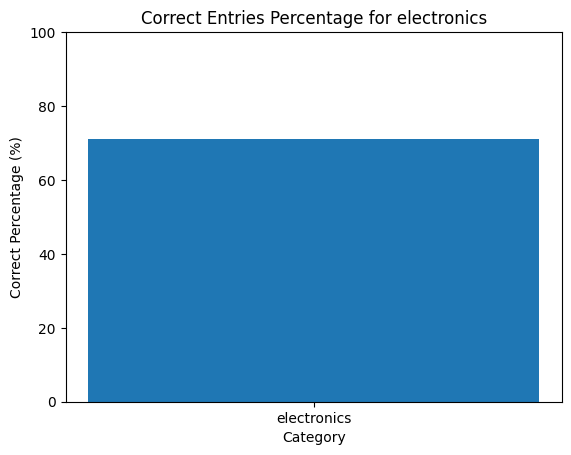

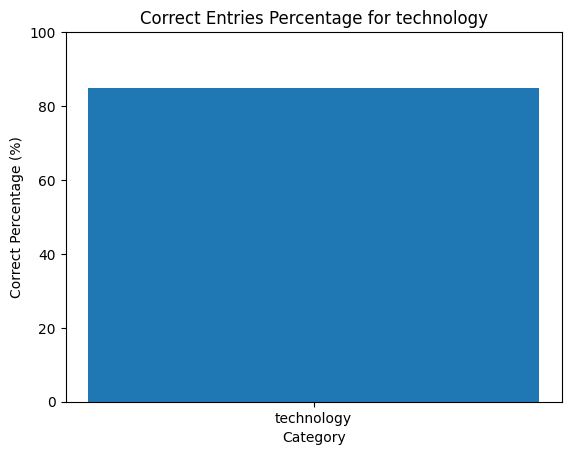

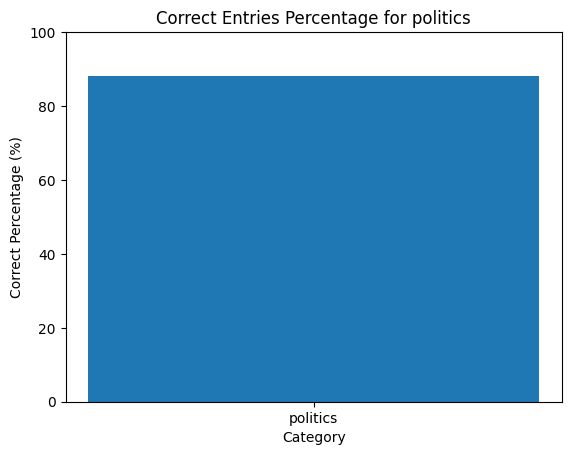

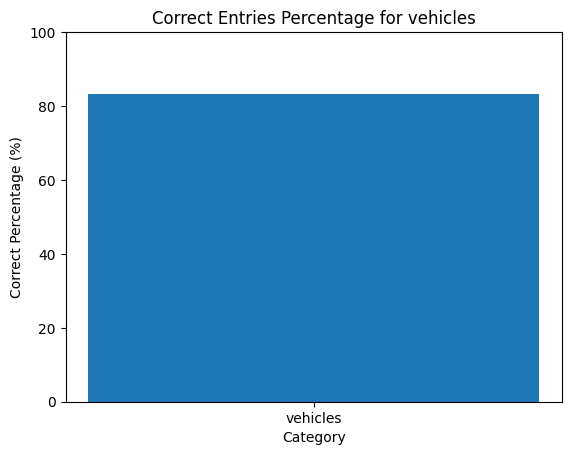

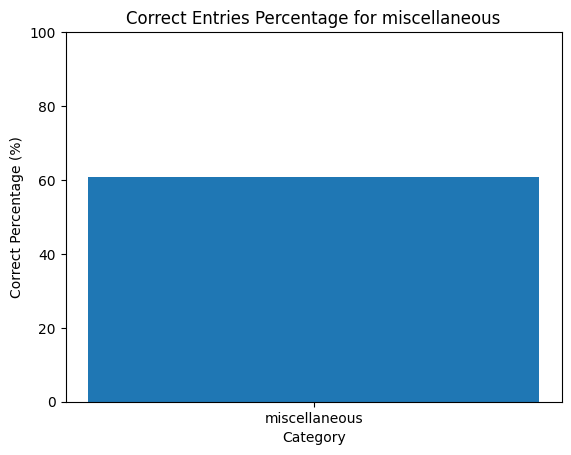

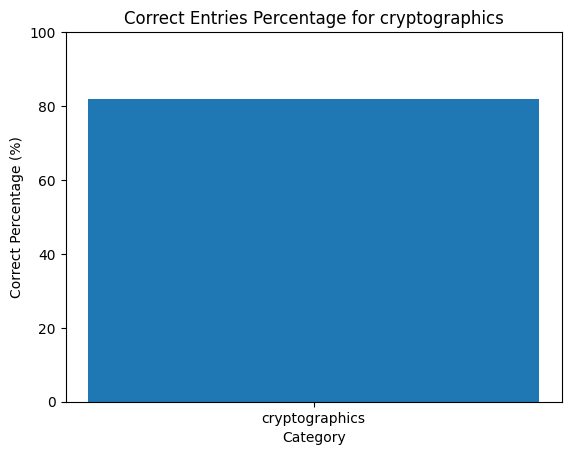

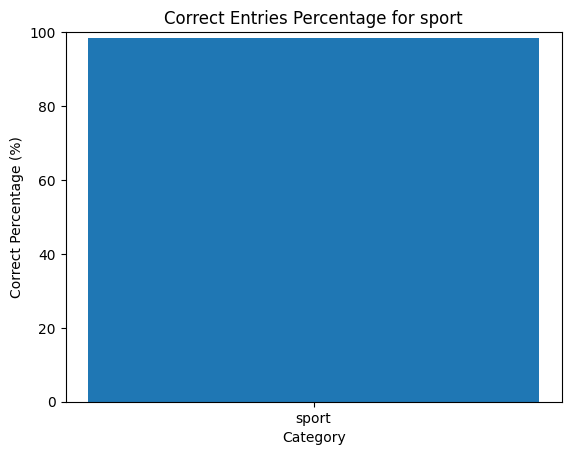

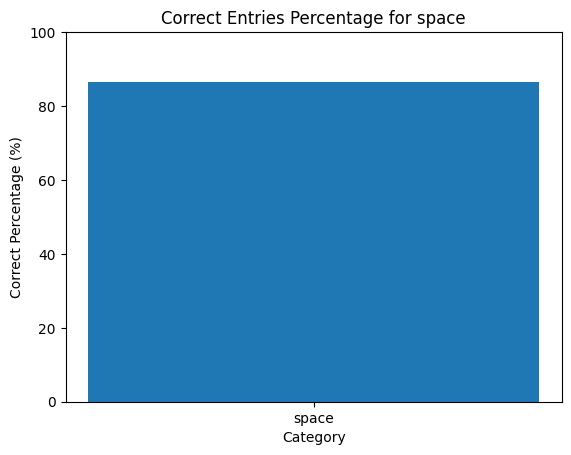

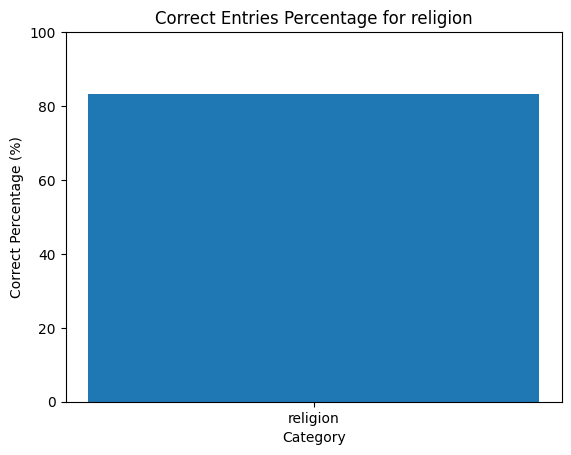

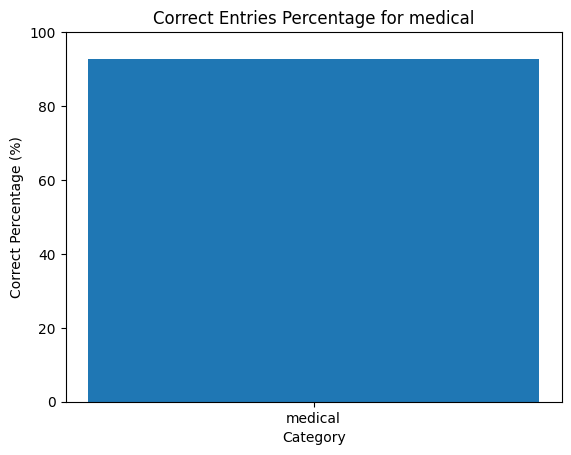

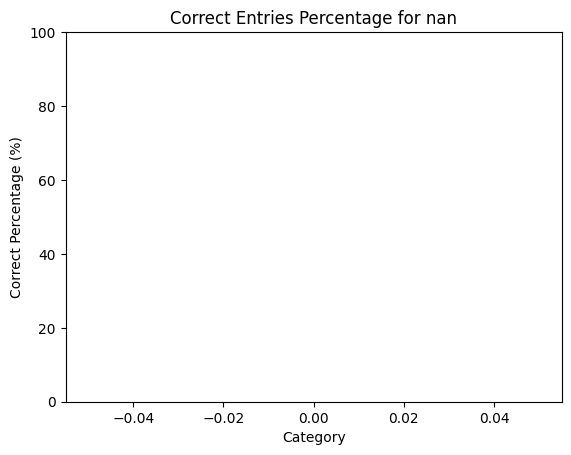

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_correct_entries_percentage(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Convert all entries in the 'label' column to lowercase
    df['label'] = df['label'].str.lower()

    print(df.columns)
    print(df[['label', 'result']])

    # Assuming 'result' and 'category' columns are present in the DataFrame
    categories = df['label'].unique()

    for category in categories:
        # Filter rows for the current category
        category_df = df[df['label'] == category]

        # Calculate the percentage of correct entries
        correct_entries = category_df[category_df['result'] == category]
        correct_percentage = (len(correct_entries) / len(category_df)) * 100 if len(category_df) > 0 else 0

        # Plot the barchart
        plt.figure()
        plt.bar([category], [correct_percentage])
        plt.xlabel('Category')
        plt.ylabel('Correct Percentage (%)')
        plt.title(f'Correct Entries Percentage for {category}')
        plt.ylim(0, 100)
        plt.show()


# Example usage:
plot_correct_entries_percentage(r'C:\Users\super161\Desktop\import barchart\gemini_7newsgroups.csv')
